##### Copyright 2025 Google LLC.

In [6]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# 2D spatial understanding with Gemini 2.0

<a target="_blank" href="https://colab.research.google.com/github/google-gemini/cookbook/blob/main/quickstarts/Spatial_understanding.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" height=30/></a>

## Setup

### Install SDK

The new **[Google Gen AI SDK](https://github.com/googleapis/python-genai)** provides programmatic access to Gemini 2.0 (and previous models) using both the [Google AI for Developers](https://ai.google.dev/gemini-api/docs/models/gemini-v2) and [Vertex AI](https://cloud.google.com/vertex-ai/generative-ai/docs/overview) APIs. With a few exceptions, code that runs on one platform will run on both. This means that you can prototype an application using the Developer API and then migrate the application to Vertex AI without rewriting your code.

More details about this new SDK on the [documentation](https://googleapis.github.io/python-genai/) or in the [Getting started](../quickstarts/Get_started.ipynb) notebook.

In [7]:
%pip install -U -q google-genai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.7/159.7 kB 4.6 MB/s eta 0:00:00


### Setup your API key

To run the following cell, your API key must be stored in a Colab Secret named `GOOGLE_API_KEY`. If you don't already have an API key, or you're not sure how to create a Colab Secret, see [Authentication](../quickstarts/Authentication.ipynb) for an example.

In [8]:
from google.colab import userdata
import os

GOOGLE_API_KEY=userdata.get('GOOGLE_API_KEY')

### Initialize SDK client

With the new SDK you now only need to initialize a client with your API key.

In [9]:
from google import genai
from google.genai import types

client = genai.Client(api_key=GOOGLE_API_KEY)

### Select and configure a model

Spatial understanding works best [Gemini 2.0 Flash model](https://ai.google.dev/gemini-api/docs/models/gemini-v2). It's even better with 2.5 models like `gemini-2.5-pro-exp-03-25` but slightly slower as it's a [thinking](./Get_started_thinking.ipynb) model.

Some features, like segmentation, only works with 2.5 models.

You can try with the older ones but it might be more inconsistent (`gemini-1.5-flash-001` had the best results of the previous generation). The [Object detection](https://github.com/google-gemini/cookbook/blob/gemini-1.5-archive/examples/Object_detection.ipynb) contains good examples of what previous models were able to do.

For more information about all Gemini models, check the [documentation](https://ai.google.dev/gemini-api/docs/models/gemini) for extended information on each of them.

In [10]:
model_name = "gemini-2.5-pro-exp-03-25" # @param ["gemini-1.5-flash-latest","gemini-2.0-flash-lite","gemini-2.0-flash","gemini-2.5-pro-exp-03-25"] {"allow-input":true}

### Import

Import all the necessary modules.

In [11]:
import google.generativeai as genai
from PIL import Image

import io
import os
import requests
from io import BytesIO

### Utils

Some scripts will be needed to draw the bounding boxes. Of course they are just examples and you are free to just write your own.

For example the [Spatial understanding example](https://aistudio.google.com/starter-apps/spatial) from [AI Studio](https://aistudio.google.com) uses HML to render the bounding boxes. You can find its code in the [Github repo](https://github.com/google-gemini/starter-applets/tree/main/spatial).

In [12]:
# @title Parsing JSON output
def parse_json(json_output: str):
    # Parsing out the markdown fencing
    lines = json_output.splitlines()
    for i, line in enumerate(lines):
        if line == "```json":
            json_output = "\n".join(lines[i+1:])  # Remove everything before "```json"
            json_output = json_output.split("```")[0]  # Remove everything after the closing "```"
            break  # Exit the loop once "```json" is found
    return json_output

In [13]:
# @title Plotting Util

# Get Noto JP font to display janapese characters
!apt-get install fonts-noto-cjk  # For Noto Sans CJK JP

#!apt-get install fonts-source-han-sans-jp # For Source Han Sans (Japanese)

import json
import random
import io
from PIL import Image, ImageDraw, ImageFont
from PIL import ImageColor

additional_colors = [colorname for (colorname, colorcode) in ImageColor.colormap.items()]

def plot_bounding_boxes(im, bounding_boxes):
    """
    Plots bounding boxes on an image with markers for each a name, using PIL, normalized coordinates, and different colors.

    Args:
        img_path: The path to the image file.
        bounding_boxes: A list of bounding boxes containing the name of the object
         and their positions in normalized [y1 x1 y2 x2] format.
    """

    # Load the image
    img = im
    width, height = img.size
    print(img.size)
    # Create a drawing object
    draw = ImageDraw.Draw(img)

    # Define a list of colors
    colors = [
    'red',
    'green',
    'blue',
    'yellow',
    'orange',
    'pink',
    'purple',
    'brown',
    'gray',
    'beige',
    'turquoise',
    'cyan',
    'magenta',
    'lime',
    'navy',
    'maroon',
    'teal',
    'olive',
    'coral',
    'lavender',
    'violet',
    'gold',
    'silver',
    ] + additional_colors

    # Parsing out the markdown fencing
    bounding_boxes = parse_json(bounding_boxes)

    font = ImageFont.truetype("NotoSansCJK-Regular.ttc", size=14)

    # Iterate over the bounding boxes
    for i, bounding_box in enumerate(json.loads(bounding_boxes)):
      # Select a color from the list
      color = colors[i % len(colors)]

      # Convert normalized coordinates to absolute coordinates
      abs_y1 = int(bounding_box["box_2d"][0]/1000 * height)
      abs_x1 = int(bounding_box["box_2d"][1]/1000 * width)
      abs_y2 = int(bounding_box["box_2d"][2]/1000 * height)
      abs_x2 = int(bounding_box["box_2d"][3]/1000 * width)

      if abs_x1 > abs_x2:
        abs_x1, abs_x2 = abs_x2, abs_x1

      if abs_y1 > abs_y2:
        abs_y1, abs_y2 = abs_y2, abs_y1

      # Draw the bounding box
      draw.rectangle(
          ((abs_x1, abs_y1), (abs_x2, abs_y2)), outline=color, width=4
      )

      # Draw the text
      if "label" in bounding_box:
        draw.text((abs_x1 + 8, abs_y1 + 6), bounding_box["label"], fill=color, font=font)

    # Display the image
    img.show()

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
Suggested packages:
  fonts-noto-cjk-extra
The following NEW packages will be installed:
  fonts-noto-cjk
0 upgraded, 1 newly installed, 0 to remove and 34 not upgraded.
Need to get 61.2 MB of archives.
After this operation, 93.2 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 fonts-noto-cjk all 1:20220127+repack1-1 [61.2 MB]
Fetched 61.2 MB in 5s (12.0 MB/s)
Selecting previously unselected package fonts-noto-cjk.
(Reading database ... 126332 files and directories currently installed.)
Preparing to unpack .../fonts-noto-cjk_1%3a20220127+repack1-1_all.deb ...
Unpacking fonts-noto-cjk (1:20220127+repack1-1) ...
Setting up fonts-noto-cjk (1:20220127+repack1-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...


## Search within an image

Let's complicate things and search within the image for specific objects.

In [36]:
!pip install easyocr


  Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl (664.8 MB)
ERROR: Operation cancelled by user
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/cli/base_command.py", line 179, in exc_logging_wrapper
    status = run_func(*args)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/cli/req_command.py", line 67, in wrapper
    return func(self, options, args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/commands/install.py", line 447, in run
    conflicts = self._determine_conflicts(to_install)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/commands/install.py", line 578, in _determine_conflicts
    return check_install_conflicts(to_install)
           ^^^^^^^^^^^^^^

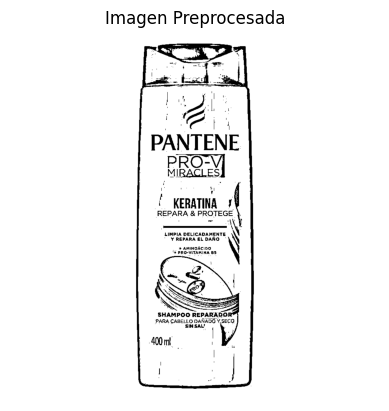

Texto detectado:
PANTENE
PRO"
MIRACLES
KERATINA
REPARA
PROTEGE
Limpia DELICADAMENTE
RePaRA EL DaRo
Ahinoacido
PRo-Vitamina B5
SHAMPOO REPARADOR
PARA CABELLO DAÑ'DO Y SECQ
SIN SAL'
400ml


In [53]:
import cv2
import easyocr
import matplotlib.pyplot as plt
import requests
import numpy as np

# 1. Leer la imagen desde la URL
image_url = "https://farmacityar.vtexassets.com/arquivos/ids/254903-1200-auto?v=638506137049230000&width=1200&height=auto&aspect=true"
response = requests.get(image_url)
response.raise_for_status()  # Verifica si la solicitud fue exitosa

# Decodificar imagen desde bytes
image_array = np.asarray(bytearray(response.content), dtype="uint8")
image = cv2.imdecode(image_array, cv2.IMREAD_COLOR)

# 2. Preprocesamiento: convertir a escala de grises
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Aplicar umbral adaptativo (mejora el contraste para OCR)
thresh = cv2.adaptiveThreshold(
    gray, 255,
    cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
    cv2.THRESH_BINARY,
    31, 2
)

# 3. Guardar y mostrar imagen preprocesada
cv2.imwrite("preprocesada.png", thresh)  # Opcional: guardar para revisar
plt.imshow(thresh, cmap='gray')
plt.axis('off')
plt.title("Imagen Preprocesada")
plt.show()

# 4. Usar EasyOCR (con idioma español o inglés según el producto)
reader = easyocr.Reader(['es', 'en'])  # Podés usar solo ['es'] si es todo en español
result = reader.readtext(thresh, detail=0)


# 5. Guardar y mostrar resultados
texto_detectado = "\n".join(result)  # Une las líneas con saltos de línea

print("Texto detectado:")
print(texto_detectado)



In [56]:
import re

# Unir el resultado de EasyOCR en un solo string (si no lo hiciste ya)
texto_detectado = "\n".join(result)

# Limpiar el texto
texto_limpio = re.sub(r'[^\w\s&%.\-]', '', texto_detectado)  # Elimina caracteres no deseados
texto_limpio = re.sub(r'\s+', ' ', texto_limpio).strip()     # Reemplaza saltos de línea/múltiples espacios por uno solo

# Mostrar el texto limpio
print("Texto limpio:")
print(texto_limpio)



Texto limpio:
PANTENE PRO MIRACLES KERATINA REPARA PROTEGE Limpia DELICADAMENTE RePaRA EL DaRo Ahinoacido PRo-Vitamina B5 SHAMPOO REPARADOR PARA CABELLO DAÑDO Y SECQ SIN SAL 400ml


In [57]:
import re



# Lista de tipos de productos en las tres categorías
productos_dermatologia = [
   "Gel limpiador facial", "Jabón de cara", "Jabón corporal", "Exfoliante facial", "Exfoliante corporal",
   "Hidratante facial", "Crema hidratante corporal", "Crema para piel seca", "Crema antiarrugas",
   "Sérum antienvejecimiento", "Mascarilla facial hidratante", "Mascarilla purificante", "Mascarilla exfoliante",
   "Cremas con ácido hialurónico", "Cremas con vitamina C", "Cremas con retinol", "Protector solar facial",
   "Protector solar corporal", "Crema para quemaduras solares", "Crema para rosácea", "Crema para psoriasis",
   "Tratamiento para acné", "Geles antiacné", "Crema para dermatitis atópica", "Crema para la piel sensible",
   "Cremas con niacinamida", "Cremas despigmentantes", "Tratamientos para manchas solares",
   "Tratamiento para hiperpigmentación", "Gel calmante para irritaciones", "Crema para cicatrices", "Crema para estrías",
   "Tónico facial", "Tónico astringente", "Gel refrescante para piernas cansadas", "Crema para quemaduras",
   "Aceite para piel seca", "Aceite esencial para la piel", "Crema para uñas quebradizas", "Crema para pies secos",
   "Crema para manos secas", "Cremas para piel grasa", "Cremas para piel mixta", "Desodorante sin alcohol",
   "Desodorante antitranspirante", "Cremas para cuidado de tatuajes", "Gel para el cuidado del cuero cabelludo",
   "Aceite de rosa mosqueta", "Aceite de argán", "Bálsamo para labios", "Crema para ojos (antiarrugas)",
   "Crema para ojeras", "Crema de contorno de ojos", "Exfoliante de labios", "Crema reparadora para la piel",
   "Crema para cicatrices quirúrgicas", "Pomada antibiótica para la piel", "Crema con colágeno",
   "Mascarilla facial anti-edad", "Spray refrescante facial", "Aceite corporal hidratante", "Tónico calmante",
   "Loción corporal para piel seca", "Cremas para piel con acné rosáceo", "Crema antimicrobiana para la piel",
   "Cremas para picazón o prurito", "Crema para dermatitis seborreica", "Geles para estrías", "Mascarilla capilar reparadora",
   "Shampoo para cuero cabelludo sensible", "Aceite para el cabello seco", "Geles antibacterianos para la piel",
   "Pomada para hongos en la piel"
]


productos_maquillaje = [
   "Base de maquillaje", "Base en polvo", "Base líquida", "Base en crema", "Corrector de ojeras",
   "Corrector de imperfecciones", "Polvo traslúcido", "Polvo compacto", "Blush (rubor)", "Bronzer",
   "Highlighter (iluminador)", "Contorno facial", "Sérum de maquillaje", "Primers o prebases de maquillaje",
   "Spray fijador de maquillaje", "Pintalabios", "Brillo de labios", "Lápiz labial mate", "Lápiz labial líquido",
   "Lápiz para cejas", "Gel para cejas", "Sombra de ojos", "Sombra en crema", "Sombra en polvo",
   "Delineador de ojos", "Delineador líquido", "Delineador en gel", "Delineador en lápiz", "Máscara de pestañas (rímel)",
   "Tintes para cejas", "Tinte de pestañas", "Fijador de cejas", "Desmaquillante facial", "Desmaquillante de ojos",
   "Toallitas desmaquillantes", "Aceite desmaquillante", "Limpiador bifásico", "Limpiador micelar",
   "Crema para desmaquillar", "Exfoliante facial de maquillaje", "Spray fijador de cejas", "Pestañas postizas",
   "Pegamento para pestañas postizas", "Bálsamo reparador de labios", "Exfoliante labial", "Kit para cejas",
   "Sombra de cejas en polvo", "Tinte para labios", "Pintura para cara (body paint)", "Brillo de cuerpo",
   "Cejas en gel", "Cejas en lápiz", "Base con SPF (protección solar)", "Líquido matificante para rostro",
   "Póster para rostro (para igualar el tono de piel)"
]


productos_higiene = [
   "Shampoo", "Acondicionador", "Jabón de cuerpo", "Gel de baño", "Exfoliante corporal",
   "Desodorante", "Pasta de dientes", "Enjuague bucal", "Bálsamo para labios", "Gel para el cuidado del cuero cabelludo",
   "Cepillo de dientes", "Jabón en barra", "Jabón líquido para manos", "Toallitas húmedas", "Desinfectante para manos",
   "Toallitas desmaquillantes", "Jabón antibacteriano"
]


# Lista de tamaños comunes
tamanos = [
   "50 ml", "100 ml", "150 ml", "200 ml", "250 ml", "500 ml", "1 L", "30 g", "50 g", "100 g", "150 g",
   "200 g", "250 g", "500 g", "1 kg", "5 oz", "10 oz", "15 oz", "20 oz"
]


# Lista de marcas comunes
marcas = [
   "L'Oréal", "Neutrogena", "Nivea", "Dove", "Garnier", "Olay", "Vichy", "La Roche", "Clinique", "Aveeno",
   "Eucerin", "Bioderma", "Vaseline", "Lush", "L'Occitane", "Rimmel", "Maybelline", "Revlon", "Estée Lauder",
   "Mac", "Urban Decay", "Shiseido", "Fenty Beauty", "Too Faced", "Tarte", "Nars", "Farsali", "Becca", "ELF",
   "ColourPop", "Milani", "It Cosmetics", "Kiehl's", "Dermalogica", "Origins", "Caudalie", "La Mer", "Clarins",
   "Elizabeth Arden", "Burt's Bees", "Sally Hansen", "Vaseline", "Pantene", "Head & Shoulders", "Aussie",
   "Herbal Essences", "TRESemmé", "Schwarzkopf", "Aveda", "Moroccanoil", "Living Proof"
]



In [74]:

# Regex para detección más flexible
regex_marcas = r"(" + "|".join(map(re.escape, marcas)) + r")"
regex_productos = r"(" + "|".join(map(re.escape, productos_dermatologia + productos_maquillaje + productos_higiene)) + r")"
regex_tamanos = r"(" + "|".join(map(re.escape, tamanos)) + r")"


# Buscar coincidencias para marcas, productos y tamaños
marcas_en_texto = re.findall(regex_marcas, texto_limpio, re.IGNORECASE)
productos_en_texto = re.findall(regex_productos, texto_limpio, re.IGNORECASE)
tamanos_en_texto = re.findall(regex_tamanos, texto_limpio, re.IGNORECASE)

# Imprimir los resultados de la búsqueda
print(f"Marcas encontradas: {marcas_en_texto}")
print(f"Productos encontrados: {productos_en_texto}")
print(f"Tamaños encontrados: {tamanos_en_texto}")

# Si se encuentran coincidencias, imprimir los detalles
if marcas_en_texto and productos_en_texto and tamanos_en_texto:
    # Tomamos el primer resultado de cada lista (puedes modificar esto si quieres más coincidencias)
    marca = marcas_en_texto[0]
    producto = productos_en_texto[0]
    tamano = tamanos_en_texto[0]

    # Diccionario para normalizar nombres de marcas
    marca_normalizada = {m.lower(): m for m in marcas}

    # Normalizar la marca
    marca_key = marca.lower()
    marca_final = marca_normalizada.get(marca_key, marca)

    print(f"Marca: {marca_finaxl}")
    print(f"Producto: {producto}")
    print(f"Tamaño: {tamano}")
else:
    print("No se encontraron coincidencias.")



Marcas encontradas: ['PANTENE']
Productos encontrados: ['SHAMPOO']
Tamaños encontrados: []
No se encontraron coincidencias.


In [73]:
import requests
from bs4 import BeautifulSoup

def obtener_ingredientes(producto):
    # Formamos la URL para buscar el producto en INCI Decoder
    # Necesitamos el nombre del producto en formato adecuado para la URL
    producto_url = f"https://www.incidecoder.com/products/{producto.replace(' ', '-').lower()}"

    try:
        # Realizamos la petición para acceder a la página del producto
        response = requests.get(producto_url)
        response.raise_for_status()

        # Usamos BeautifulSoup para analizar el HTML de la página
        soup = BeautifulSoup(response.text, 'html.parser')

        # Buscamos la lista de ingredientes
        ingredientes = soup.find('div', class_='ingredients-list')  # Ajusta según el HTML de la página
        if ingredientes:
            ingredientes_texto = ingredientes.get_text().strip()
            print(f"Ingredientes obtenidos desde INCI Decoder: {ingredientes_texto}")
            return ingredientes_texto
        else:
            print("No se encontraron ingredientes en la página del producto.")
            return None

    except requests.exceptions.RequestException as e:
        print(f"Error al intentar acceder a INCI Decoder: {e}")
        return None

# Entrada: nombre del producto
producto = "pantene-daily-moisture-renewal-shampoo"  # Ejemplo de nombre de producto

# Llamamos a la función para obtener los ingredientes
ingredientes = obtener_ingredientes(producto)

if ingredientes:
    print(f"Ingredientes del producto: {ingredientes}")
else:
    print("No se pudo obtener la lista de ingredientes.")



No se encontraron ingredientes en la página del producto.
No se pudo obtener la lista de ingredientes.
